In [1]:
import lbcred, os, random, ccdproc
from lbcred import image, interactive, tools, reduce, detection, utils
from astropy.nddata import CCDData
import numpy as np
from astropy.stats import mad_std
import ccdproc, glob
from astropy.table import Column, Table, vstack
from lbcred import project_dir


%matplotlib inline
%config InlineBackend.figure_format='retina'

# New imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy import log
from astropy.modeling import models, fitting
from scipy.stats import chisquare
from astropy.io import ascii
import astromatic_wrapper as aw
from astropy.coordinates import SkyCoord

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy.coordinates import Longitude, Latitude, AltAz

In [2]:
# Get images, run SE
in_dir = '/Users/kirstencasey/m81_astrometry_out/'

flux_apers = '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20'
num_apers = len(utils.list_of_strings(flux_apers))
extra_params = f'ALPHA_J2000,DELTA_J2000,ISOAREA_IMAGE,FLUX_APER({num_apers})'

sci_ims = glob.glob(in_dir+'sci/lbc*reg.fits')
cali_ims = glob.glob(in_dir+'cali/lbc*reg.fits')
cali_cats_r = []
sci_cats_r = []
cali_cats_b = []
sci_cats_b = []

# Run SE on images, store catalogs 
for ftype, ims in zip(['cali','sci'],[cali_ims,sci_ims]):

    for im in ims:
        fn_base = im.split('/')[-1].split('.fits')[0]
        cat_fn = os.path.join(in_dir,f'{ftype}/catalogs/{fn_base}.cat')
        cat = detection.sextractor.run(im,DETECT_MINAREA=3,DETECT_THRESH=10,PIXEL_SCALE=0.225,PHOT_APERTURES=flux_apers,
                             catalog_path=cat_fn,extra_params=extra_params)

        star_query = 'FLAGS==0 and ISOAREA_IMAGE > 5 and \
                  FWHM_IMAGE > 1 and FWHM_IMAGE < 26'
        cat = cat[cat.to_pandas().query(star_query).index.values]
        
        cat['filename'] = fn_base+'.fits'
        
        if 'lbcr' in fn_base:
            if ftype == 'cali': cali_cats_r.append(cat)
            else: sci_cats_r.append(cat)

        else: 
            if ftype == 'cali': cali_cats_b.append(cat)
            else: sci_cats_b.append(cat)
                


In [3]:
def get_date_time(cat):
    date = cat['filename'][0].split('.')[1]
    time = int(cat['filename'][0].split('.')[2].split('-')[0])
    
    return date, time

def find_closest_cat(given_cat,cats_to_search):
    
    '''
    This function finds the catalog that corresponds to the closest matching time stamp of the given catalog. 
    Ex. If you give it a catalog as given_cat, it finds the closest matching time stamp of all the catalogs in 
    cats_to_search. 
    Assumes there is at least one catalog in cats_to_search that has the same date as the given_cat
    '''
    
    given_date, given_time = get_date_time(given_cat)
    
    # Loop through cats_to_search 
    closest_diff = 10000000 
    for cat in cats_to_search:
        date, time = get_date_time(cat)
        
        if date == given_date:
            diff = abs(given_time - time)
            if diff < closest_diff:
                closest_diff = diff
                closest_cat = cat
            
        
    return closest_cat


lbt = EarthLocation.of_site('Large Binocular Telescope')

def calculate_air_mass(skycoord, utc_time, location):
    """
    Assumes approximation from Hardie (1962).
    """
    utc_time = Time(utc_time, format='isot')
    nms_altaz = AltAz(obstime=utc_time, location=location)
    target_nms = skycoord.transform_to(nms_altaz)
    secz = target_nms.secz.value
    air_mass = secz -  0.0018167 * (secz - 1) -\
                       0.0028750 * (secz - 1)**2 -\
                       0.0008083 * (secz - 1)**3
    return air_mass

def find_largest_airmass_diff(cat):
    end = len(cat)
    diff = 0
    ind1 = 0
    ind2 = 1
    for i in range(len(cat)):
        j=i+1
        while j < end:
            if abs(cat[i]-cat[j]) > diff:
                diff = abs(cat[i]-cat[j])
                ind1 = i
                ind2 = j
            j+=1
    return cat[np.array([ind1,ind2])]

def make_region_files(cat, ftype, coordtype='physical'):
    
    out_dir = f'/Users/kirstencasey/m81_astrometry_out/{ftype}/'
    
    files = np.array([])
    filenames = np.array([])
    
    if ftype == 'cali': color = 'blue'
    else: color = 'red'
    
    for star in cat:
        if coordtype == 'J2000':
            x = star['ALPHA_J2000']
            y = star['DELTA_J2000']
            line = f'J2000; circle {x}d {y}d 3p\n'
        elif coordtype == 'physical':
            x = star['X_IMAGE']
            y = star['Y_IMAGE']
            line = f'circle {x} {y} 3p\n'
        
        if star['filename'] in filenames:
            
            # Add to existing region file
            file = files[np.where(filenames==star['filename'])][0]
            file.write(line)
        else:
            # Make new region file
            fname = star['filename']
            filenames = np.append(filenames,fname)
            
            file = open(os.path.join(out_dir,fname.replace('.fits','.reg')),'w')
            file.write(f'global color={color}\n')
            file.write(line)
            files = np.append(files,file)
            
    # Save all files
    for file in files:
        file.close()

    return

'''
cats = [cat_all_sci_r,cat_all_sci_b,cat_all_cali_r,cat_all_cali_b]
types = ['sci','sci','cali','cali']
for cat,ftype in zip(cats,types):
    make_region_files(cat, ftype)
'''

In [7]:
## Make aperture plots and color term plots
# http://spiff.rit.edu/richmond/sne/sn2011fe/color_terms.html
in_dir = '/Users/kirstencasey/m81_astrometry_out/'
panstarrs = Table.read(in_dir+'panstarrs-137.6-73.4_withBESSEL.dat',format='ascii')
panstarrs_coord = SkyCoord(panstarrs['ra'],panstarrs['dec'],unit='deg')
texp_cali = 30.262 # seconds
texp_sci = 300.281 # seconds
gain = 1.75

allowed_sep = 5 # arcsec

cat_all_cali_r = []
cat_all_cali_b = []
cat_all_cali_p = []
cat_all_sci_r = []
cat_all_sci_b = []
cat_all_sci_p = []

for ftype, cats in zip(['cali','sci'],[cali_cats_r,sci_cats_r]):
    
    # Get catalogs to compare to
    if ftype == 'cali':
        cats_to_search = cali_cats_b
    else: cats_to_search = sci_cats_b
        
    
    for cat_r in cats:
        cat_b = find_closest_cat(cat_r,cats_to_search)
        
        r_coord = SkyCoord(cat_r['ALPHA_J2000'],cat_r['DELTA_J2000'],unit='deg')
        b_coord = SkyCoord(cat_b['ALPHA_J2000'],cat_b['DELTA_J2000'],unit='deg')
        
        ## Match and organize catalogs
        # Find r-band obj that appear in panstarrs
        idx_r_to_p, sep_r_to_p, _ = r_coord.match_to_catalog_sky(panstarrs_coord)
        mask_r_to_p = sep_r_to_p.arcsec < allowed_sep
        obj_in_panstarrs_r = cat_r[mask_r_to_p]
        
        # Find b-band obj that appear in panstarrs
        idx_b_to_p, sep_b_to_p, _ = b_coord.match_to_catalog_sky(panstarrs_coord)
        mask_b_to_p = sep_b_to_p.arcsec < allowed_sep
        obj_in_panstarrs_b = cat_b[mask_b_to_p]
        
        # Find smaller of the catalogs matched to panstarrs
        len_b = len(obj_in_panstarrs_b)
        len_r = len(obj_in_panstarrs_r)
        if len_b < len_r:
            obj_in_panstarrs_small = obj_in_panstarrs_b
            obj_in_panstarrs_large = obj_in_panstarrs_r
        else:
            obj_in_panstarrs_small = obj_in_panstarrs_r
            obj_in_panstarrs_large = obj_in_panstarrs_b
        
        # Match the smaller catalog to the larger catalog (both of which have been matched to panstarrs) and vice versa
        obj_in_panstarrs_small_coord = SkyCoord(obj_in_panstarrs_small['ALPHA_J2000'],obj_in_panstarrs_small['DELTA_J2000'],unit='deg')
        obj_in_panstarrs_large_coord = SkyCoord(obj_in_panstarrs_large['ALPHA_J2000'],obj_in_panstarrs_large['DELTA_J2000'],unit='deg')
        
        idx, sep, _ = obj_in_panstarrs_small_coord.match_to_catalog_sky(obj_in_panstarrs_large_coord)
        mask = sep.arcsec < allowed_sep
        obj_in_panstarrs_small = obj_in_panstarrs_small[mask]
        obj_in_panstarrs_large = obj_in_panstarrs_large[idx[mask]]
        '''
        idx, sep, _ = obj_in_panstarrs_large_coord.match_to_catalog_sky(obj_in_panstarrs_small_coord)
        mask = sep.arcsec < allowed_sep
        '''
        if len(obj_in_panstarrs_large) == 0: continue
        
        if 'lbcr' in obj_in_panstarrs_large[0]['filename']:
            obj_in_panstarrs_r = obj_in_panstarrs_large#[mask]
            obj_in_panstarrs_b = obj_in_panstarrs_small#[idx]
        else:
            obj_in_panstarrs_b = obj_in_panstarrs_large#[mask]
            obj_in_panstarrs_r = obj_in_panstarrs_small#[idx]
        
        
        # Now both obj_in_panstars catalogs should have all the same matching objects in the same order
        # Get objects in Pan-STARRS that match to the obj_in_panstarrs catalogs
        obj_in_panstarrs_coord = SkyCoord(obj_in_panstarrs_r['ALPHA_J2000'],obj_in_panstarrs_r['DELTA_J2000'],unit='deg')
        idx, sep, _ = obj_in_panstarrs_coord.match_to_catalog_sky(panstarrs_coord)
        panstarrs_matched = panstarrs[idx]

        # Phew! Catalog cross-matching complete. Now calculate mags and stuff!
        
        # Get instrumental magnitudes for b- and r-bands
        if ftype == 'cali':
            obj_in_panstarrs_b['mag_inst'] = -2.5 * np.log10(obj_in_panstarrs_b['FLUX_APER_3']*gain/texp_cali)
            obj_in_panstarrs_r['mag_inst'] = -2.5 * np.log10(obj_in_panstarrs_r['FLUX_APER_3']*gain/texp_cali)
        else:
            obj_in_panstarrs_b['mag_inst'] = -2.5 * np.log10(obj_in_panstarrs_b['FLUX_APER_3']*gain/texp_sci)
            obj_in_panstarrs_r['mag_inst'] = -2.5 * np.log10(obj_in_panstarrs_r['FLUX_APER_3']*gain/texp_sci)

        # Find airmass
        lbt = EarthLocation.of_site('Large Binocular Telescope')
        hdul_b = fits.open(os.path.join(in_dir,ftype,obj_in_panstarrs_b[0]['filename']))
        hdul_r = fits.open(os.path.join(in_dir,ftype,obj_in_panstarrs_r[0]['filename']))
        utc_time_r = hdul_r[0].header['DATE_OBS']
        utc_time_b = hdul_b[0].header['DATE_OBS']
        
        #(get other stuff from header) - do all this at the beginning later
        obj_in_panstarrs_r['Back_c00'] = hdul_r[0].header['BACKSUB_PARAMVALS_0']
        obj_in_panstarrs_b['Back_c00'] = hdul_b[0].header['BACKSUB_PARAMVALS_0']
        obj_in_panstarrs_r['Back_c01'] = hdul_r[0].header['BACKSUB_PARAMVALS_2']
        obj_in_panstarrs_b['Back_c01'] = hdul_b[0].header['BACKSUB_PARAMVALS_2']
        obj_in_panstarrs_r['Back_c10'] = hdul_r[0].header['BACKSUB_PARAMVALS_1']
        obj_in_panstarrs_b['Back_c10'] = hdul_b[0].header['BACKSUB_PARAMVALS_1']
        obj_in_panstarrs_r['readnoise'] = hdul_r[0].header['RDNOISE']
        obj_in_panstarrs_b['readnoise'] = hdul_b[0].header['RDNOISE']
        
        coord_r = SkyCoord(obj_in_panstarrs_r['ALPHA_J2000'],obj_in_panstarrs_r['DELTA_J2000'],unit='deg')
        coord_b = SkyCoord(obj_in_panstarrs_b['ALPHA_J2000'],obj_in_panstarrs_b['DELTA_J2000'],unit='deg')
        
        obj_in_panstarrs_b['airmass'] = calculate_air_mass(coord_b, utc_time_b, lbt)
        obj_in_panstarrs_r['airmass'] = calculate_air_mass(coord_r, utc_time_r, lbt)
        hdul_b.close()
        hdul_r.close()

        # Re-determine which catalog is which
        if ftype == 'cali':
            if len(cat_all_cali_r) == 0:
                cat_all_cali_r = obj_in_panstarrs_r
                cat_all_cali_b = obj_in_panstarrs_b
                cat_all_cali_p = panstarrs_matched
            else:
                cat_all_cali_r = vstack([cat_all_cali_r,obj_in_panstarrs_r])
                cat_all_cali_b = vstack([cat_all_cali_b,obj_in_panstarrs_b])
                cat_all_cali_p = vstack([cat_all_cali_p,panstarrs_matched])
        else:
            if len(cat_all_sci_r) == 0: 
                cat_all_sci_r = obj_in_panstarrs_r
                cat_all_sci_b = obj_in_panstarrs_b
                cat_all_sci_p = panstarrs_matched
            else:
                cat_all_sci_r = vstack([cat_all_sci_r,obj_in_panstarrs_r])
                cat_all_sci_b = vstack([cat_all_sci_b,obj_in_panstarrs_b])
                cat_all_sci_p = vstack([cat_all_sci_p,panstarrs_matched])
    
    
    if ftype == 'cali': 
        make_region_files(cat_all_cali_r, ftype,'J2000')
        make_region_files(cat_all_cali_b, ftype,'J2000')
    else: 
        make_region_files(cat_all_sci_r, ftype,'J2000')
        make_region_files(cat_all_sci_b, ftype,'J2000')
    


/Users/kirstencasey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
# The catalogs should all the sorted now. 

for ftype in ['cali','sci']:
    
    ## Remove bad detections by hand
    if ftype == 'cali':
        cali_mask = cat_all_cali_b['filename']!='lbcb.20191220.074517-chip2_backsub_M81blob.proc_reg.fits'
        cali_mask += cat_all_cali_b['X_IMAGE']!=2504.963
        cali_mask += cat_all_cali_r['filename']!='lbcr.20191220.074504-chip2_backsub_M81blob.proc_reg.fits'
        cat_all_cali_b = cat_all_cali_b[cali_mask]
        cat_all_cali_r = cat_all_cali_r[cali_mask]

    else:
        sci_mask = cat_all_sci_r['filename']!='lbcr.20191220.081411-chip2_backsub_M81blob.proc_reg.fits'
        sci_mask += cat_all_sci_b['filename']!='lbcb.20191220.081414-chip2_backsub_M81blob.proc_reg.fits'
        sci_mask += cat_all_sci_r['X_IMAGE']!=1943.785
        sci_mask += cat_all_sci_b['X_IMAGE']!=1944.455
        cat_all_sci_r = cat_all_sci_r[sci_mask]
        cat_all_sci_b = cat_all_sci_b[sci_mask]
    
    ## Apply extinction correction
    '''
    # Find repeated observations of stars in Pan-STARRS
    arr, ind, counts = np.unique(cat_all_sci_p, return_index=True, return_counts=True)
    repeated_stars_p = cat_all_sci_p[ind[counts>1]]

    for star in repeated_stars_p:
        match = np.where(cat_all_sci_p == star)
        star_obs_r = cat_all_sci_r[match]
        star_obs_b = cat_all_sci_b[match]
        
        if len(star_obs_r) > 2:
            
        


        ext_coeff = 


    # Calculate extinction coefficient

    # Apply correction
    '''
    
    ## Calculate S/N for various apertures
    apers_diameter = utils.list_of_strings(flux_apers) # flux_apers comes from previous cell
    apertures = []
    
    if ftype == 'cali':
        cat_all_cali_r['FLUX_APER'].name = 'FLUX_APER_0'
        cat_all_cali_b['FLUX_APER'].name = 'FLUX_APER_0'
        for col in cat_all_cali_r.columns:
            if 'FLUX_APER' in col: apertures.append(col)


        for aper in apertures:
            aper_num = aper.split('_')[-1]
            npix = np.pi * (int(apers_diameter[int(aper_num)])/2)**2

            back_r = (cat_all_cali_r['Back_c00'] + cat_all_cali_r['Back_c10']*cat_all_cali_r['X_IMAGE'] + cat_all_cali_r['Back_c01']*cat_all_cali_r['Y_IMAGE'])*gain
            back_b = (cat_all_cali_b['Back_c00'] + cat_all_cali_b['Back_c10']*cat_all_cali_b['X_IMAGE'] + cat_all_cali_b['Back_c01']*cat_all_cali_b['Y_IMAGE'])*gain


            cat_all_cali_r[f'S/N_{aper_num}'] = (cat_all_cali_r[aper]*gain)/(np.sqrt((cat_all_cali_r[aper]*gain) + (back_r*npix) + ((cat_all_cali_r['readnoise']**2 * npix) + ((gain/2)**2 * npix))))
            cat_all_cali_b[f'S/N_{aper_num}'] = (cat_all_cali_b[aper]*gain)/(np.sqrt((cat_all_cali_b[aper]*gain) + (back_b*npix) + ((cat_all_cali_b['readnoise']**2 * npix) + ((gain/2)**2 * npix))))
    
    else:
        cat_all_sci_r['FLUX_APER'].name = 'FLUX_APER_0'
        cat_all_sci_b['FLUX_APER'].name = 'FLUX_APER_0'
        for col in cat_all_sci_r.columns:
            if 'FLUX_APER' in col: apertures.append(col)


        for aper in apertures:
            aper_num = aper.split('_')[-1]
            npix = np.pi * (int(apers_diameter[int(aper_num)])/2)**2
            
            back_r = (cat_all_sci_r['Back_c00'] + cat_all_sci_r['Back_c10']*cat_all_sci_r['X_IMAGE'] + cat_all_sci_r['Back_c01']*cat_all_sci_r['Y_IMAGE'])*gain
            back_b = (cat_all_sci_b['Back_c00'] + cat_all_sci_b['Back_c10']*cat_all_sci_b['X_IMAGE'] + cat_all_sci_b['Back_c01']*cat_all_sci_b['Y_IMAGE'])*gain


            cat_all_sci_r[f'S/N_{aper_num}'] = (cat_all_sci_r[aper]*gain)/(np.sqrt((cat_all_sci_r[aper]*gain) + (back_r*npix) + ((cat_all_sci_r['readnoise']**2 * npix) + ((gain/2)**2 * npix))))
            cat_all_sci_b[f'S/N_{aper_num}'] = (cat_all_sci_b[aper]*gain)/(np.sqrt((cat_all_sci_b[aper]*gain) + (back_b*npix) + ((cat_all_sci_b['readnoise']**2 * npix) + ((gain/2)**2 * npix))))
    
    
    ## Plot stuff! 
    
    # Color term plot
    if ftype == 'cali':
        fig, ax = plt.subplots(2, 2, figsize=(12,10))
        fig.suptitle('Calibration Images - Color Terms',fontsize=20)
        x = cat_all_cali_b['mag_inst'] - cat_all_cali_r['mag_inst']
        y = cat_all_cali_r['mag_inst'] - cat_all_cali_p['R-BESSEL_linear']
        ax[0][0].scatter(x,y)
        ax[0][0].set_xlabel('Instrumental magnitude color (b-r)')
        ax[0][0].set_ylabel('Instrumental r - Pan-STARRS r')
        
        x = cat_all_cali_b['mag_inst'] - cat_all_cali_r['mag_inst']
        y = cat_all_cali_b['mag_inst'] - cat_all_cali_p['B-BESSEL_linear']
        ax[0][1].scatter(x,y)
        ax[0][1].set_xlabel('Instrumental magnitude color (b-r)')
        ax[0][1].set_ylabel('Instrumental b - Pan-STARRS b')
        
        x = cat_all_cali_p['R-BESSEL_linear']
        y = cat_all_cali_r['mag_inst'] - cat_all_cali_p['R-BESSEL_linear']
        ax[1][0].scatter(x,y)
        ax[1][0].set_xlabel('Pan-STARRS r magnitude')
        ax[1][0].set_ylabel('Instrumental r - Pan-STARRS r')
        
        x = cat_all_cali_p['B-BESSEL_linear']
        y = cat_all_cali_b['mag_inst'] - cat_all_cali_p['B-BESSEL_linear']
        ax[1][1].scatter(x,y)
        ax[1][1].set_xlabel('Pan-STARRS b magnitude')
        ax[1][1].set_ylabel('Instrumental b - Pan-STARRS b')
        plt.savefig(os.path.join(in_dir,ftype,'diagnostic-plots',f'colorterms.png'),overwrite=True)
        plt.show()
        plt.clf()
        
    else:
        fig, ax = plt.subplots(2, 2, figsize=(12,10))
        fig.suptitle('Science Images - Color Terms',fontsize=20)
        x = cat_all_sci_b['mag_inst'] - cat_all_sci_r['mag_inst']
        y = cat_all_sci_r['mag_inst'] - cat_all_sci_p['R-BESSEL_linear']
        ax[0][0].scatter(x,y)
        ax[0][0].set_xlabel('Instrumental magnitude color (b-r)')
        ax[0][0].set_ylabel('Instrumental r - Pan-STARRS r')
        
        x = cat_all_cali_b['mag_inst'] - cat_all_cali_r['mag_inst']
        y = cat_all_cali_b['mag_inst'] - cat_all_cali_p['B-BESSEL_linear']
        ax[0][1].scatter(x,y)
        ax[0][1].set_xlabel('Instrumental magnitude color (b-r)')
        ax[0][1].set_ylabel('Instrumental b - Pan-STARRS b')
        
        x = cat_all_sci_p['R-BESSEL_linear']
        y = cat_all_sci_r['mag_inst'] - cat_all_sci_p['R-BESSEL_linear']
        ax[1][0].scatter(x,y)
        ax[1][0].set_xlabel('Pan-STARRS r magnitude')
        ax[1][0].set_ylabel('Instrumental r - Pan-STARRS r')
        
        x = cat_all_cali_p['B-BESSEL_linear']
        y = cat_all_cali_b['mag_inst'] - cat_all_cali_p['B-BESSEL_linear']
        ax[1][1].scatter(x,y)
        ax[1][1].set_xlabel('Pan-STARRS b magnitude')
        ax[1][1].set_ylabel('Instrumental b - Pan-STARRS b')
        plt.savefig(os.path.join(in_dir,ftype,'diagnostic-plots',f'colorterms.png'),overwrite=True)
        plt.show()
        plt.clf()

In [94]:
panstarrs

ra,dec,raMeanErr,decMeanErr,nDetections,ng,gMeanPSFMag,nr,rMeanPSFMag,ni,iMeanPSFMag,nz,zMeanPSFMag,ny,yMeanPSFMag,gMeanPSFMagErr,gFlags,rMeanPSFMagErr,rFlags,iMeanPSFMagErr,iFlags,zMeanPSFMagErr,zFlags,yMeanPSFMagErr,yFlags,R-BESSEL_linear,B-BESSEL_linear,R-BESSEL_quad,B-BESSEL_quad
float64,float64,float64,float64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64
137.57879429,73.43031734,0.026249999180436134,0.028389999642968178,53,11,21.31730079650879,8,20.31760025024414,15,19.50550079345703,13,19.118499755859375,6,18.944400787353516,0.04284900054335594,115000,0.04056999832391739,16892216,0.021585000678896904,115000,0.0113129997625947,115000,0.026441000401973724,115000,20.048639478683473,22.11712501716614,20.043649956963705,22.119113940426796
137.55873659,73.45269579,0.010320000350475311,0.00634999992325902,59,10,18.684499740600586,6,18.396099090576172,22,18.3080997467041,11,18.296100616455078,10,18.3174991607666,0.009045000188052654,115000,0.015585999935865402,115000,0.004476999863982201,115000,0.012325000017881393,115000,0.009840000420808792,115000,18.220318605422975,19.066790922164916,18.225539747260434,19.059678449801932
137.49710172,73.44549204,0.003060000017285347,0.003969999961555004,64,10,18.36009979248047,8,17.531400680541992,23,17.21190071105957,11,17.04199981689453,12,16.92970085144043,0.006171000190079212,115000,0.005861000157892704,115000,0.0022330000065267086,115000,0.004352999851107597,115000,0.012996000237762928,115000,17.28484109687805,19.059546171188355,17.284985652126934,19.0562057341346
137.47627698,73.44389722,0.0067900000140070915,0.005950000137090683,59,8,20.650800704956055,6,19.38949966430664,21,18.746700286865234,12,18.445499420166016,12,18.236000061035156,0.03359999880194664,115000,0.012653999961912632,115000,0.008093000389635563,115000,0.0022479998879134655,115000,0.026712000370025635,115000,19.086269227981568,21.60418441581726,19.070143622777348,21.618174014272
137.48443361,73.45566042,0.003759999992325902,0.003160000080242753,56,8,19.122499465942383,8,18.039499282836914,21,17.626699447631836,9,17.41860008239746,10,17.29990005493164,0.011358000338077545,115000,0.006645000074058771,115000,0.004110000096261501,115000,0.009072000160813332,115000,0.01308399997651577,115000,17.759626258850098,19.971220573425292,17.751521470559936,19.976525807233642
137.46611001,73.43201083,0.0064199999906122684,0.006579999811947346,60,12,18.915199279785156,6,17.7947998046875,23,16.98509979248047,7,16.63290023803711,12,16.435100555419922,0.006874999962747097,115000,0.011447000317275524,115000,0.0028089999686926603,115000,0.003604999976232648,115000,0.006899999920278788,115000,17.510027473449707,19.78587377166748,17.50039310684678,19.792821417388623
137.5422494,73.46733336,0.008320000022649765,0.007309999782592058,52,10,20.46150016784668,7,19.32360076904297,18,18.062999725341797,10,17.47010040283203,7,17.198400497436523,0.011636000126600266,115000,0.011203000321984291,115000,0.008596000261604786,115000,0.007081999909132719,115000,0.03302399814128876,115000,19.03653594779968,21.34244711494446,19.02615799776003,21.35019594500267
137.46107562,73.42939756,0.008070000447332859,0.009100000374019146,59,12,19.837299346923828,6,19.395999908447266,21,19.302000045776367,13,19.26020050048828,7,19.1427001953125,0.019836999475955963,115000,0.029827000573277473,115000,0.01500099990516901,115000,0.02399899996817112,115000,0.03691200166940689,115000,19.200189682006837,20.30934211730957,19.205691958454203,20.30128317132639
137.66663565,73.44271729,0.004980000201612711,0.005119999870657921,60,12,19.709999084472656,8,19.094100952148438,19,18.87190055847168,13,18.781099319458008,8,18.701400756835938,0.013005999848246574,115000,0.013659999705851078,115000,0.007230000104755163,115000,0.011824999935925007,115000,0.027479000389575958,115000,18.875418296813965,20.284531288146972,18.87958336908481,20.277335683364537


In [173]:
cat_all_sci_p

ra,dec,raMeanErr,decMeanErr,nDetections,ng,gMeanPSFMag,nr,rMeanPSFMag,ni,iMeanPSFMag,nz,zMeanPSFMag,ny,yMeanPSFMag,gMeanPSFMagErr,gFlags,rMeanPSFMagErr,rFlags,iMeanPSFMagErr,iFlags,zMeanPSFMagErr,zFlags,yMeanPSFMagErr,yFlags,R-BESSEL_linear,B-BESSEL_linear,R-BESSEL_quad,B-BESSEL_quad
float64,float64,float64,float64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64
137.41771039,73.43494471,0.006120000034570694,0.004989999812096357,55,8,16.56170082092285,6,15.909899711608887,21,15.655599594116211,11,15.55150032043457,9,15.467000007629395,0.006359000224620104,115000,0.002959999954327941,115000,0.0022499999031424522,115000,0.002962999977171421,115000,0.006428000051528215,115000,15.686513766288757,17.15730807209015,15.690184695905995,17.150546957028915
137.37011405,73.46484889,0.009469999931752682,0.005100000184029341,50,6,19.637500762939453,7,19.144399642944336,15,18.94890022277832,11,18.876699447631836,11,18.725000381469727,0.025374000892043114,115000,0.018578000366687775,115000,0.0062339999713003635,115000,0.018364999443292618,115000,0.03144500032067299,115000,18.941803396224977,20.139951120376587,18.94709340926319,20.131932041951114
137.41771039,73.43494471,0.006120000034570694,0.004989999812096357,55,8,16.56170082092285,6,15.909899711608887,21,15.655599594116211,11,15.55150032043457,9,15.467000007629395,0.006359000224620104,115000,0.002959999954327941,115000,0.0022499999031424522,115000,0.002962999977171421,115000,0.006428000051528215,115000,15.686513766288757,17.15730807209015,15.690184695905995,17.150546957028915
137.91983937,73.55894567,0.01018999982625246,0.011420000344514847,43,8,21.03969955444336,6,19.963199615478516,13,18.894399642944336,6,18.404199600219727,10,18.185199737548828,0.04431400075554848,115000,0.032255999743938446,115000,0.010355999693274498,115000,0.01925799995660782,115000,0.02844800055027008,115000,19.684178123474123,21.884605018615723,19.676330910631165,21.889634492539916
137.94145855,73.50563637,0.010820000432431698,0.01066999975591898,51,8,21.129899978637695,8,19.945899963378906,13,19.403499603271484,15,19.09819984436035,7,18.985700607299805,0.028665000572800636,115000,0.02631000056862831,115000,0.011594999581575394,115000,0.013574999757111073,115000,0.06144699826836586,115000,19.652795961380004,22.037907987594604,19.640374136683107,22.0478670923501
137.40387262,73.42224355,0.015350000001490116,0.036309998482465744,61,12,21.024499893188477,6,19.80109977722168,19,18.741199493408203,13,18.231700897216797,11,17.970199584960938,0.053467001765966415,115000,0.03853800147771835,115000,0.009003999643027782,115000,0.006926999893039465,115000,0.008856999687850475,16892216,19.50283436203003,21.955635761260986,19.488568037228585,21.967598424353433
137.86828297,73.43593706,0.0016799999866634607,0.00215999991632998,58,12,17.732900619506836,10,16.85919952392578,12,16.51129913330078,11,16.371999740600586,13,16.26609992980957,0.004751000087708235,115000,0.0015829999465495348,115000,0.002348999958485365,115000,0.002469999948516488,115000,0.008324000053107738,115000,16.606744680404663,18.458763162612914,16.60570255107486,18.456632451200168
137.40387262,73.42224355,0.015350000001490116,0.036309998482465744,61,12,21.024499893188477,6,19.80109977722168,19,18.741199493408203,13,18.231700897216797,11,17.970199584960938,0.053467001765966415,115000,0.03853800147771835,115000,0.009003999643027782,115000,0.006926999893039465,115000,0.008856999687850475,16892216,19.50283436203003,21.955635761260986,19.488568037228585,21.967598424353433
137.33770658,73.36743059,0.004530000034719706,0.006209999788552523,53,6,20.002700805664062,8,18.819700241088867,18,18.155099868774414,11,17.858600616455078,10,17.64259910583496,0.062174998223781586,16892216,0.013624000363051891,115000,0.007007000036537647,115000,0.010629000142216682,115000,0.023756999522447586,115000,18.526727167129515,20.910122137069703,18.514350960376973

In [235]:
cat_all_sci_r

X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUX_RADIUS,FWHM_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLAGS,ALPHA_J2000,DELTA_J2000,ISOAREA_IMAGE,FLUX_APER_0,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUX_APER_14,FLUX_APER_15,FLUX_APER_16,FLUX_APER_17,FLUX_APER_18,FLUX_APER_19,filename,mag_inst,Back_c00,Back_c01,Back_c10,readnoise,airmass,S/N_0,S/N_1,S/N_2,S/N_3,S/N_4,S/N_5,S/N_6,S/N_7,S/N_8,S/N_9,S/N_10,S/N_11,S/N_12,S/N_13,S/N_14,S/N_15,S/N_16,S/N_17,S/N_18,S/N_19
pix,pix,ct,pix,pix,pix,pix,deg,,deg,deg,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,ct,,,,,,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str56,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1860.287,3294.033,53329.57,3.24,6.17,1.351,1.284,-3.6,0,137.4186922,73.4360955,24,879.5929,3525.657,7506.057,12644.67,18408.62,24056.97,29597.93,34539.76,39005.95,42447.56,45431.5,47801.29,49698.44,51160.86,52315.84,53016.3,53439.77,53626.16,53861.77,53972.9,lbcr.20191220.074623-chip2_backsub_M81blob.proc_reg.fits,-4.668544237068549,8500.585687984836,-0.009190829331691,-0.04722084246253937,12.0,1.4372156363411905,13.39516937882759,26.952992350577244,38.406167286014174,48.680767391279275,56.912717138826594,62.273946162741055,65.96732432878389,67.66426474832363,68.20332627446201,67.07134852761001,65.49027091684971,63.36304194532534,60.97787081698135,58.42929078719341,55.881847721187995,53.190113910173885,50.543899288830836,47.97130048521328,45.701509988371136,43.55225767107957
2362.899,3157.102,769744.1,2.657,4.79,2.448,2.307,-22.4,0,137.371147,73.4641017,163,16712.77,76268.69,156021.8,254724.1,349988.8,442969.4,515624.6,579271.6,626478.6,666095.2,693454.1,716453.0,733093.8,746739.8,756848.8,764868.2,771169.4,776279.6,780623.3,784625.4,lbcr.20191220.075324-chip2_backsub_M81blob.proc_reg.fits,-7.928950579117718,8882.705395610074,-0.00159647980577872,-0.05137102629617428,12.0,1.4273375988816994,143.69603755827578,313.06825023403627,442.05304815242124,557.8711958893767,640.8173191307848,705.1252069039284,738.6747881716993,758.9349409818767,761.7554867534635,757.2816974526149,742.6770737689808,725.4426777250223,704.4002523577636,682.5203086881335,659.5564310773026,636.6840000143127,614.1926261828801,592.4318920220269,571.6360419796187,552.0049316668754
1860.621,3293.991,54499.81,2.653,4.79,1.626,1.481,-37.5,0,137.4191487,73.4347399,38,1543.866,5265.429,11385.4,18151.61,25308.54,31554.12,37101.78,41569.52,45187.62,48052.59,50411.06,52123.15,53554.29,54451.96,54853.93,55275.73,55485.15,55257.52,55085.22,54913.47,lbcr.20191220.075324-chip2_backsub_M81blob.proc_reg.fits,-5.061063367633139,8882.705395610074,-0.00159647980577872,-0.05137102629617428,12.0,1.4271262856776386,22.12142663578418,38.3798535056016,55.53764129280805,66.96088599449122,75.27296561790781,78.89232350328251,80.1312011185328,79.11816547507618,76.91812952044637,74.0011488508179,70.88393912585764,67.43663386275168,64.15822917588586,60.73906967812011,57.244364533743415,54.18527641380441,51.27757303768266,48.30334107483879,45.67651277111485,43.30449565431235
2095.331,300.979,795805.0,3.474,6.03,2.916,2.807,-25.5,0,137.9186284,73.558779,201,12583.06,49268.2,107285.0,175262.3,253190.2,328365.0,401921.4,466817.3,524668.0,573511.1,615509.5,649972.5,679510.9,703272.9,723959.1,740776.8,754937.4,766835.1,777153.6,785646.4,lbcr.20191220.073926-chip2_backsub_M81blob.proc_reg.fits,-7.522996754796014,8553.566616153303,-0.00698984920511395,-0.0440957409111709,12.0,1.4526523215709048,119.79001388122575,23

In [229]:
cat_all_sci_b

X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUX_RADIUS,FWHM_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLAGS,ALPHA_J2000,DELTA_J2000,ISOAREA_IMAGE,FLUX_APER_0,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUX_APER_14,FLUX_APER_15,FLUX_APER_16,FLUX_APER_17,FLUX_APER_18,FLUX_APER_19,filename,mag_inst,Back_c00,Back_c01,Back_c10,readnoise,airmass,S/N_0,S/N_1,S/N_2,S/N_3,S/N_4,S/N_5,S/N_6,S/N_7,S/N_8,S/N_9,S/N_10,S/N_11,S/N_12,S/N_13,S/N_14,S/N_15,S/N_16,S/N_17,S/N_18,S/N_19
pix,pix,ct,pix,pix,pix,pix,deg,,deg,deg,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,ct,,,,,,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str56,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1860.628,3293.905,31757.29,3.816,6.55,1.536,1.272,-15.5,0,137.4186745,73.4361081,27,409.3276,1634.871,3387.501,5747.408,8280.417,11106.55,14031.87,16886.64,19550.63,21872.82,24039.29,25788.67,27221.98,28426.09,29342.59,30122.59,30662.8,31202.86,31665.32,31994.08,lbcb.20191220.074630-chip2_backsub_M81blob.proc_reg.fits,-3.8124555583685864,1726.084095732743,-0.00119591336667376,-0.00791889310730717,12.0,1.4370532309647432,12.64777837575602,25.698548961245695,35.945707384735755,46.02355388234214,53.51601748965898,60.245315132083064,65.69384721010803,69.66819738534599,72.21006235568383,73.23815315134084,73.65291782014576,72.8957273119416,71.45451531749973,69.65993095163965,67.44579574933766,65.19507563672038,62.7102939772422,60.47509838505206,58.31630239817432,56.12810317170026
2362.839,3157.494,227311.5,3.496,6.66,2.864,2.596,-49.2,0,137.3710899,73.4640831,162,3190.165,12943.16,27324.79,47674.63,68793.36,92142.39,114109.7,135003.5,153203.9,168833.2,181632.1,192256.5,200501.9,207529.7,212819.1,216977.4,220129.2,222716.1,224711.8,226410.1,lbcb.20191220.075327-chip2_backsub_M81blob.proc_reg.fits,-6.109493815982866,1718.204271696538,-0.00047874915571683,-0.00847455006447378,12.0,1.4272614973319484,62.187145963106815,126.37400771547682,182.10004137383945,239.94934333306446,284.6713911791081,325.5293934816632,356.290448390273,380.4227581415948,396.51490915937285,406.27997275757053,410.2676218577664,410.27766874680736,406.4543324287945,400.93793208182234,393.1457529729863,384.1548116520118,374.25535926797994,364.13545631999676,353.79446038135825,343.6425289545957
1860.821,3293.704,33625.22,3.371,6.65,1.866,1.674,-57.2,0,137.4191682,73.434761,46,491.1596,1995.71,4195.511,7265.87,10634.12,14244.55,17650.31,20676.97,23380.64,25627.57,27559.48,29042.01,30274.87,31309.55,32183.87,32793.93,33279.52,33521.5,33665.89,33806.18,lbcb.20191220.075327-chip2_backsub_M81blob.proc_reg.fits,-4.066994546129611,1718.204271696538,-0.00047874915571683,-0.00847455006447378,12.0,1.4270510725812706,14.868459193315372,30.643148266808588,43.46732074556573,56.7099838004694,66.97251753136065,75.41742378631973,80.94569360122512,83.90521734718669,85.22977531520662,84.93342976501522,83.78964412909306,81.6250170245612,79.12865931469418,76.48041905877628,73.78939794153524,70.84847132743714,67.97023078854257,64.92356386184841,61.99207683026975,59.3199837370919
2095.286,301.121,71824.44,4.054,7.25,2.415,2.07,-37.1,0,137.9186089,73.5587716,79,809.9891,3316.235,7144.31,12195.25,17740.19,23748.18,29666.28,35577.21,40705.39,45648.73,49857.25,53838.43,57060.45,59931.49,62286.9,64284.66,65934.9,67376.52,68665.28,69740.45,lbcb.20191220.073931-chip2_backsub_M81blob.proc_reg.fits,-4.629252257200908,1722.955642805118,-0.00077418126111548,-0.00834912159247059,12.0,1.4525111405204518,22.680918853409917

In [227]:
cat_all_cali_b

X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUX_RADIUS,FWHM_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLAGS,ALPHA_J2000,DELTA_J2000,ISOAREA_IMAGE,FLUX_APER_0,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUX_APER_14,FLUX_APER_15,FLUX_APER_16,FLUX_APER_17,FLUX_APER_18,FLUX_APER_19,filename,mag_inst,Back_c00,Back_c01,Back_c10,readnoise,airmass,S/N_0,S/N_1,S/N_2,S/N_3,S/N_4,S/N_5,S/N_6,S/N_7,S/N_8,S/N_9,S/N_10,S/N_11,S/N_12,S/N_13,S/N_14,S/N_15,S/N_16,S/N_17,S/N_18,S/N_19
pix,pix,ct,pix,pix,pix,pix,deg,,deg,deg,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,ct,,,,,,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str56,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2504.963,1420.08,48986.27,0.68,4.33,0.758,0.705,-89.1,0,137.6441088,73.5403609,6,14590.39,42590.79,66120.71,59991.8,50368.48,39049.16,33522.92,43351.08,52593.64,50554.88,49329.44,30156.39,10985.88,12405.87,14011.91,14234.53,14277.81,-16.86983,-14131.88,-24257.36,lbcb.20191220.075217-chip2_backsub_M81blob.proc_reg.fits,-8.850580786250399,171.9779274062548,-0.00034840163642955,-0.00016924558826572,12.0,1.431660395609716,156.49506212285684,266.1087956694816,328.1470682947585,302.7959688425525,263.5476774722935,213.52640936339768,181.0368053990569,205.45129949817326,224.18257478377197,206.86829882318452,192.76437177432283,121.4911829038483,45.47752587736575,47.75777109438235,50.389314394856676,48.260740106214755,45.80074981301842,-0.05340390650727357,-44.00921865299536,-73.3611990638309
2363.141,3157.52,31011.29,4.451,7.02,2.286,2.034,-61.9,0,137.3715132,73.4643925,74,306.7977,1301.156,2768.343,4763.134,6865.829,9332.06,11596.55,13791.92,15686.59,17402.79,18810.57,20090.29,21167.81,22213.35,23130.76,23953.22,24729.77,25520.51,26254.16,27039.42,lbcb.20191220.075217-chip2_backsub_M81blob.proc_reg.fits,-6.100083053320389,171.9779274062548,-0.00034840163642955,-0.00016924558826572,12.0,1.4289073936394523,13.337013998313948,28.965799607438257,41.78008663280136,54.35853033750594,63.63521827849059,72.81481725072419,78.707780097083,83.07026148703012,85.24346294557546,86.28985467073645,85.92801547093336,85.11748575777412,83.67533459189787,82.2838716524343,80.62847621895243,78.85059502851364,77.11083212142032,75.57131252169997,74.01742837984033,72.7274188016346
497.141,4433.828,65.34632,0.051,4.86,1.018,0.656,-12.8,0,137.404867,73.3258724,7,872.4928,1686.218,2364.919,2737.827,2503.524,1324.149,175.9195,-1915.463,-3699.765,-4586.138,-5013.871,-5130.196,-5358.732,-6114.24,-6926.392,-7840.232,-8475.471,-8297.508,-8552.119,-11280.94,lbcb.20191220.074517-chip2_backsub_M81blob.proc_reg.fits,-5.49886605967537,170.8615356209526,-0.00021737507878255,-0.00023609345029547,12.0,1.4370328074339285,29.905819681436466,35.68468720922142,36.716979312201246,33.95678004858485,26.219633050316187,12.18753081869598,1.430632757454401,-14.079251928545348,-24.564647972076017,-27.41534436429689,-27.129186964680912,-25.299792204017223,-24.300962792667903,-25.735159348577596,-27.200347184335506,-28.86147953212174,-29.327961643252387,-27.018729200622776,-26.33323528470477,-33.14620243995842
497.141,4433.828,65.34632,0.051,4.86,1.018,0.656,-12.8,0,137.404867,73.3258724,7,872.4928,1686.218,2364.919,2737.827,2503.524,1324.149,175.9195,-1915.463,-3699.765,-4586.138,-5013.871,-5130.196,-5358.732,-6114.24,-6926.392,-7840.232,-8475.471,-8297.508,-8552.119,-11280.94,lbcb.20191220.074517-chip2_backsub_M81blob.proc_reg.fits,-5.49886605967537,170.8615356209526,-0.00021737507878255,-0.000236093450295

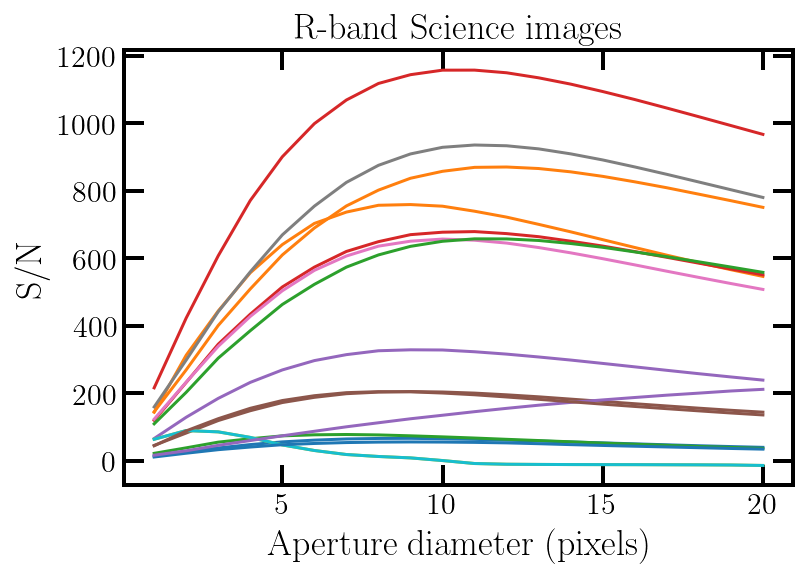

In [10]:
x=[]
for string in apers_diameter:
    x.append(int(string))
x = np.asarray(x)   

for star in cat_all_sci_r:
    
    y = []
    for i in range(len(x)):
        y.append(star[f'S/N_{str(i)}'])
    y = np.asarray(y)
    
    plt.plot(x,y)
plt.xlabel('Aperture diameter (pixels)')
plt.ylabel('S/N')
plt.title('R-band Science images')
plt.savefig(in_dir+'signal_to_noise_sci_r.png')

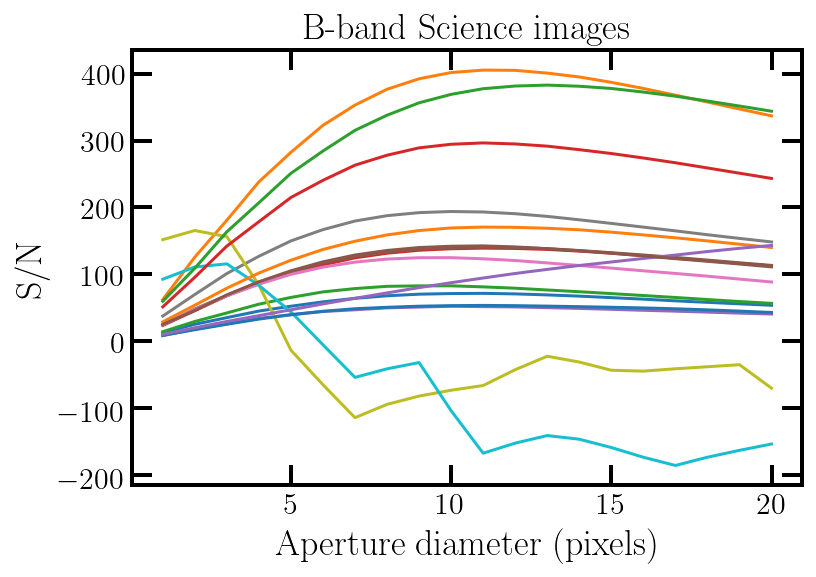

In [11]:
x=[]
for string in apers_diameter:
    x.append(int(string))
x = np.asarray(x)   

for star in cat_all_sci_b:
    
    y = []
    for i in range(len(x)):
        y.append(star[f'S/N_{str(i)}'])
    y = np.asarray(y)
    
    plt.plot(x,y)
plt.xlabel('Aperture diameter (pixels)')
plt.ylabel('S/N')
plt.title('B-band Science images')
plt.savefig(in_dir+'signal_to_noise_sci_b.png')

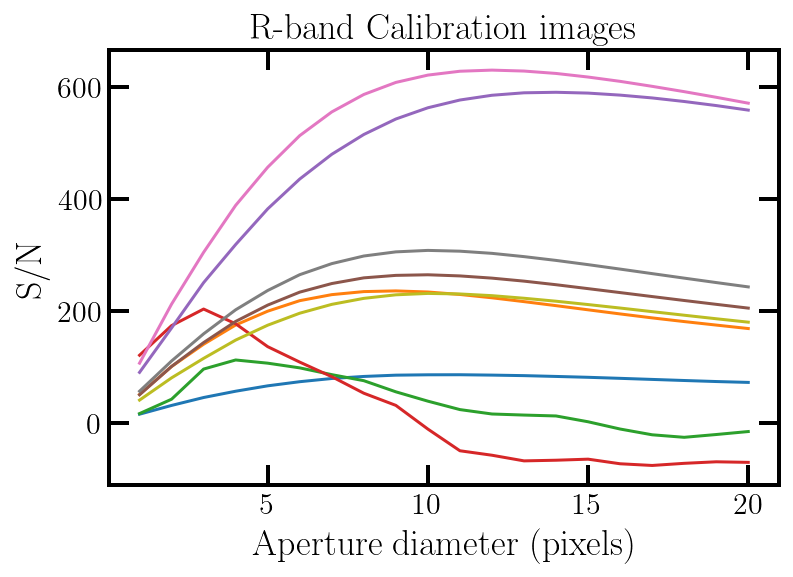

In [12]:
x=[]
for string in apers_diameter:
    x.append(int(string))
x = np.asarray(x)   

for star in cat_all_cali_r:
    
    y = []
    for i in range(len(x)):
        y.append(star[f'S/N_{str(i)}'])
    y = np.asarray(y)
    
    plt.plot(x,y)
plt.xlabel('Aperture diameter (pixels)')
plt.ylabel('S/N')
plt.title('R-band Calibration images')
plt.savefig(in_dir+'signal_to_noise_cali_r.png')

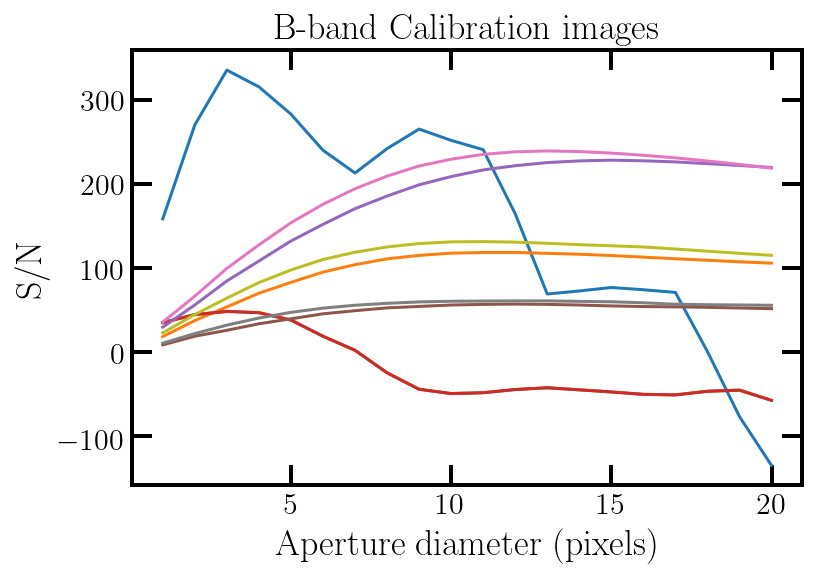

In [13]:
x=[]
for string in apers_diameter:
    x.append(int(string))
x = np.asarray(x)   

for star in cat_all_cali_b:
    
    y = []
    for i in range(len(x)):
        y.append(star[f'S/N_{str(i)}'])
    y = np.asarray(y)
    
    plt.plot(x,y)
plt.xlabel('Aperture diameter (pixels)')
plt.ylabel('S/N')
plt.title('B-band Calibration images')
plt.savefig(in_dir+'signal_to_noise_cali_b.png')

In [ ]:
notstar = ['lbcr.20191220.080015-chip2_backsub_M81blob.proc_reg.fits','lbcb.20191220.080018-chip2_backsub_M81blob.proc_reg.fits']
#not star: (1943.785,1449.609,3), (1944.455,1451.055,3)
#edge: (1440.776,4289.712,3)
edge = ['lbcr.20191220.081411-chip2_backsub_M81blob.proc_reg.fits','lbcb.20191220.081414-chip2_backsub_M81blob.proc_reg.fits']

In [12]:
mask = cat_all_sci_r['filename']=='lbcr.20191220.080015-chip2_backsub_M81blob.proc_reg.fits'
mask &= 

cat_all_sci_r = cat_all_sci_r[np.where(cat_all_sci_r['filename'] != 'lbcr.20191220.081411-chip2_backsub_M81blob.proc_reg.fits')]

In [13]:
len(cat_all_sci_r)

14

In [14]:
cat_all_sci_r['filename']=='lbcr.20191220.080015-chip2_backsub_M81blob.proc_reg.fits'

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False])

In [29]:
cat_all_cali_r[cat_all_cali_r['filename']!='lbcr.20191220.075203-chip2_backsub_M81blob.proc_reg.fits']

X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUX_RADIUS,FWHM_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLAGS,ALPHA_J2000,DELTA_J2000,ISOAREA_IMAGE,FLUX_APER,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUX_APER_14,FLUX_APER_15,FLUX_APER_16,FLUX_APER_17,FLUX_APER_18,FLUX_APER_19,filename,mag_inst,Back_c00,Back_c01,Back_c10,readnoise,airmass
pix,pix,ct,pix,pix,pix,pix,deg,,deg,deg,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,ct,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str56,float64,float64,float64,float64,float64,float64
496.62,4430.049,7410.806,1.125,6.25,1.573,0.698,0.3,0,137.4053258,73.3260381,7,414.6152,2277.256,9010.889,13353.41,14485.5,14968.67,14475.7,13893.55,10977.23,8236.605,5384.11,3853.94,3650.449,3458.977,507.0719,-3634.385,-7317.699,-9342.522,-8012.568,-6336.886,lbcr.20191220.074504-chip2_backsub_M81blob.proc_reg.fits,-7.219331513589338,841.4415781149062,-0.00080563978180368,-0.00468931544230405,12.0,1.4373564233498017
510.046,4430.789,19043.31,0.549,1.68,0.795,0.723,89.4,0,137.4034136,73.3266696,6,8951.225,19679.38,28817.1,25784.77,20011.99,16935.55,13761.9,9374.324,5927.115,-2276.042,-10494.99,-13216.86,-16706.5,-17800.02,-18647.97,-22327.88,-24733.57,-25044.83,-25560.52,-27348.15,lbcr.20191220.074504-chip2_backsub_M81blob.proc_reg.fits,-7.9337592090190965,841.4415781149062,-0.00080563978180368,-0.00468931544230405,12.0,1.4373550848543952
1787.775,2847.633,356819.9,3.771,6.49,3.168,3.08,2.4,0,137.4989046,73.4463227,252,5297.776,19056.47,41792.82,68479.82,99738.07,131493.5,162427.1,191229.4,217364.6,240030.8,259438.9,275743.4,289532.2,301019.0,310890.3,319173.2,326364.0,332455.8,337730.0,342166.0,lbcr.20191220.082645-chip2_backsub_M81blob.proc_reg.fits,-8.99425757968607,930.6834537589881,-2.7181638822732e-05,-0.00447279580088517,12.0,1.386280250285054
2217.351,1239.644,100669.0,3.032,5.39,2.382,2.156,-60.5,0,137.6418403,73.5408503,105,2005.808,8114.03,16854.24,27628.97,38655.52,49668.25,59355.27,67974.01,74901.02,80707.1,85296.97,89015.91,91988.14,94304.32,96127.12,97690.21,98991.12,100070.3,100986.0,101721.2,lbcr.20191220.083345-chip2_backsub_M81blob.proc_reg.fits,-8.008762791494217,982.1616430911262,0.000675315564350107,-0.00539307306041792,12.0,1.3811754709574888
1787.752,2847.909,356488.6,3.044,5.36,2.758,2.548,-55.5,0,137.4980419,73.4456741,199,7196.422,28584.66,59497.23,97707.09,136857.9,175618.8,209947.9,239677.3,264480.5,284291.4,300221.1,312887.9,323004.9,331256.2,337883.2,343495.4,348067.3,352065.2,355439.8,358257.7,lbcr.20191220.083345-chip2_backsub_M81blob.proc_reg.fits,-9.380166251705273,982.1616430911262,0.000675315564350107,-0.00539307306041792,12.0,1.3788905822074269
1629.748,3506.451,115719.6,3.003,5.59,2.394,2.271,-13.6,0,137.4045304,73.4221151,116,2362.307,9150.266,19282.96,31754.52,44804.22,57995.44,69746.6,80134.21,88637.77,95456.3,100640.1,104711.6,107783.9,110268.8,112180.5,113681.8,114879.0,115856.6,116649.5,117288.6,lbcr.20191220.072038-chip2_backsub_M81blob.proc_reg.fits,-8.159864935248349,856.4104144511108,-0.00022532267637442,-0.00476517753556556,12.0,1.478176659361621
2157.262,3741.261,82634.7,3.241,6.12,2.415,2.217,13.1,0,137.3012465,73.4426924,101,1409.609,5577.706,11744.7,19761.64,28410.13,37221.03,45511.89,52955.12,59390.87,64706.08,68839.34,72144.22,74705.63,76841.93,78508.75,79872.16,80921.56,81782.66,82461.91,83031.35,lbcr.20191220.072038-chip2_backsub_M81blob.proc_reg.fits,-7.644908512978845,856.4104144511108,-0.00022532267637442,-0.00476517753556556,12.0,1.4777629001549768


In [21]:
cat_all_cali_r['filename']=='lbcr.20191220.075203-chip2_backsub_M81blob.proc_reg.fits'

array([ True,  True, False, False, False, False, False])

In [18]:
cat_all_cali_b

X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUX_RADIUS,FWHM_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLAGS,ALPHA_J2000,DELTA_J2000,ISOAREA_IMAGE,FLUX_APER_0,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUX_APER_14,FLUX_APER_15,FLUX_APER_16,FLUX_APER_17,FLUX_APER_18,FLUX_APER_19,filename,mag_inst,Back_c00,Back_c01,Back_c10,readnoise,airmass,S/N_0,S/N_1,S/N_2,S/N_3,S/N_4,S/N_5,S/N_6,S/N_7,S/N_8,S/N_9,S/N_10,S/N_11,S/N_12,S/N_13,S/N_14,S/N_15,S/N_16,S/N_17,S/N_18,S/N_19
pix,pix,ct,pix,pix,pix,pix,deg,,deg,deg,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,ct,,,,,,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct
float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str56,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2363.123,3157.533,28933.18,4.224,6.99,2.28,1.99,-57.8,0,137.3715134,73.4643911,72,320.2287,1305.827,2748.014,4719.036,6828.034,9232.43,11469.98,13637.07,15478.85,17153.97,18510.16,19729.97,20739.9,21717.25,22562.46,23310.26,24000.49,24705.19,25342.53,26030.73,lbcb.20191220.075217-chip2_backsub_M81blob.proc_reg.fits,-6.089984280499225,171.9779274062548,-0.00034840163642955,-0.00016924558826572,12.0,1.4289073720692527,18.593320222000923,37.68447995551832,53.96546274297465,70.23203807700423,83.1535083496667,95.39495338190028,104.17591596367042,111.10448630423527,115.21389106297252,117.90879442620604,118.67623934646788,118.6789884745889,117.68861430967866,116.61356511422476,115.04719629420201,113.18986237506546,111.2332670705012,109.46572556257631,107.568995830983,105.97961877386119
1787.984,2848.03,73778.75,4.779,8.26,2.903,2.797,-72.3,0,137.4987974,73.4462978,140,676.0592,2450.776,5554.097,9252.23,13902.62,18730.0,24037.47,29119.43,34288.15,38865.59,43195.77,46867.32,50286.74,53227.34,55864.95,57991.25,59909.28,61563.3,63172.54,64614.11,lbcb.20191220.082658-chip2_backsub_M81blob.proc_reg.fits,-6.820967105138889,197.1810242496655,-0.00045002687302433,-0.00160818976005405,12.0,1.38605807232813,29.934216327681973,56.29189947561251,84.82192135686854,108.53424268311436,132.3265334857512,152.1304962958215,170.8281839757557,185.80984707268615,199.23732171819674,208.9897920714045,216.90906651059325,221.91809453727404,225.68068185456457,227.64275971213436,228.51047385640675,227.77750294308453,226.43728904815305,224.3854111072808,222.27576848003145,219.79068687795686
2217.5,1239.541,12521.31,4.298,7.56,1.571,1.023,-76.9,0,137.6416182,73.5408699,22,125.975,558.7791,1123.807,1931.617,2798.198,3831.099,4765.499,5752.775,6595.048,7473.625,8238.366,8955.522,9548.729,10058.09,10485.16,10958.7,11501.49,11984.39,12403.37,12808.62,lbcb.20191220.083356-chip2_backsub_M81blob.proc_reg.fits,-5.120153601716307,215.9712940078824,0.001404739143254632,-0.0007305455634144,12.0,1.3809765676329842,8.77509417266447,19.101631942501015,26.133992093281037,33.88534613723005,39.76512628882892,45.73458168465432,49.43069039022409,52.80170174540956,54.522476064913754,56.20464504514211,56.9386812528149,57.2977896450969,56.94197016157494,56.19773789716963,55.13477888353866,54.39125951419201,54.021097972301774,53.436136981342386,52.64904182759195,51.87653869484598
1787.783,2848.18,69601.98,3.909,7.2,2.93,2.567,-69.4,0,137.4979902,73.4456515,146,925.1743,3280.352,7335.284,12217.68,18013.84,23997.63,29992.45,35728.32,41133.34,45740.08,49869.65,53285.37,56132.05,58446.93,60387.78,62037.78,63491.08,64668.25,65680.0,66457.31,lbcb.20191220.083356-chip2_backsub_M81blob.proc_reg.fits,-7.122822919625969,215.9712940078824,0.001404739143254632,-0.0007305455634144,12.0,1.3786920023234617,35.9055030194

In [6]:
make_region_files(cat_all_cali_r, ftype,'J2000')

/Users/kirstencasey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
